In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
! pip install tensorboardX
! pip install pytorch-ignite
% cd /content/gdrive/My\ Drive/Colab\ Notebooks/generative-query-network-pytorch-master/
import torch
from tqdm import tqdm
from gqn import GenerativeQueryNetwork, partition, Annealer
import torch
import torch.nn as nn
import random
from shepardmetzler import ShepardMetzler
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from collections import OrderedDict
def deterministic_partition(images, viewpoints, indices):
    """
    Partition batch into context and query sets.
    :param images
    :param viewpoints
    :return: context images, context viewpoint, query image, query viewpoint
    """
    # Maximum number of context points to use
    _, b, m, *x_dims = images.shape
    _, b, m, *v_dims = viewpoints.shape

    # "Squeeze" the batch dimension
    images = images.view((-1, m, *x_dims))
    viewpoints = viewpoints.view((-1, m, *v_dims))

    # Partition into context and query sets
    context_idx, query_idx = indices[:-1], indices[-1]

    x, v = images[:, context_idx], viewpoints[:, context_idx]
    x_q, v_q = images[:, query_idx], viewpoints[:, query_idx]

    return x, v, x_q, v_q

/content/gdrive/My Drive/Colab Notebooks/generative-query-network-pytorch-master


In [0]:
dataset = ShepardMetzler("/content/gdrive/My Drive/FilePortal/gqn/shepard_metzler_5_parts/") ## <= Choose your data location
loader = DataLoader(dataset, batch_size=1, shuffle=True)

In [0]:
model = GenerativeQueryNetwork(x_dim=3, v_dim=7, r_dim=256, h_dim=128, z_dim=64, L=8)

In [0]:
path = '/content/gdrive/My Drive/Colab Notebooks/generative-query-network-pytorch-master/data_dir/model-checkpoint.pth'
#model = torch.load(path, map_location=torch.device('cpu'))
state_dict = torch.load(path, map_location=torch.device('cpu'))
#state_dict = state_dict['model']

In [0]:
new_state_dict = OrderedDict()
for k, v in tqdm(state_dict.items()):
    name = k[7:]
    new_state_dict[name] = v
model.load_state_dict(new_state_dict)
model

100%|██████████| 44/44 [00:00<00:00, 17650.09it/s]


GenerativeQueryNetwork(
  (generator): GeneratorNetwork(
    (inference_core): Conv2dLSTMCell(
      (forget): Conv2d(394, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (input): Conv2d(394, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (output): Conv2d(394, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (state): Conv2d(394, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (transform): Conv2d(128, 394, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    )
    (generator_core): Conv2dLSTMCell(
      (forget): Conv2d(327, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (input): Conv2d(327, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (output): Conv2d(327, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (state): Conv2d(327, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (transform): Conv2d(128, 327, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    )
    (posterio

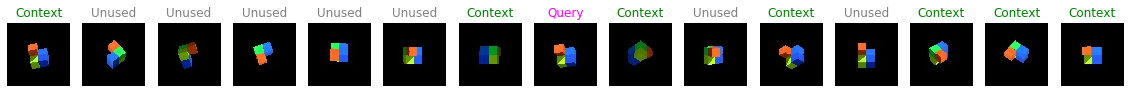

In [0]:
# Pick a scene to visualise
scene_id = 0

# Load data
x, v = next(iter(loader))
x_, v_ = x.squeeze(0), v.squeeze(0)

# Sample a set of views
n_context = 7 + 1
indices = random.sample([i for i in range(v_.size(1))], n_context)

# Seperate into context and query sets
x_c, v_c, x_q, v_q = deterministic_partition(x, v, indices)

# Visualise context and query images
f, axarr = plt.subplots(1, 15, figsize=(20, 7))
for i, ax in enumerate(axarr.flat):
    # Move channel dimension to end
    ax.imshow(x_[scene_id][i].permute(1, 2, 0))
    
    if i == indices[-1]:
        ax.set_title("Query", color="magenta")
    elif i in indices[:-1]:
        ax.set_title("Context", color="green")
    else:
        ax.set_title("Unused", color="grey")
    
    ax.axis("off")

Reconstruction using the model

In [0]:
x_c[scene_id].unsqueeze(0).shape, \
v_c[scene_id].unsqueeze(0).shape, \
x_q[scene_id].unsqueeze(0).shape, \
v_q[scene_id].unsqueeze(0).shape

(torch.Size([1, 7, 3, 64, 64]),
 torch.Size([1, 7, 7]),
 torch.Size([1, 3, 64, 64]),
 torch.Size([1, 7]))

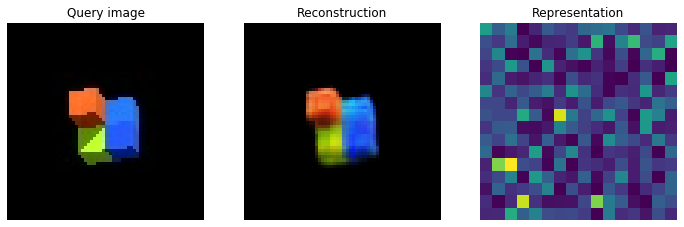

In [0]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 7))

x_mu, r, kl = model(x_c[scene_id].unsqueeze(0), 
                    v_c[scene_id].unsqueeze(0), 
                    x_q[scene_id].unsqueeze(0),
                    v_q[scene_id].unsqueeze(0))

x_mu = x_mu.squeeze(0).cpu()
r = r.squeeze(0).cpu()

ax1.imshow(x_q[scene_id].data.permute(1, 2, 0))
ax1.set_title("Query image")
ax1.axis("off")

ax2.imshow(x_mu.data.permute(1, 2, 0))
ax2.set_title("Reconstruction")
ax2.axis("off")

ax3.imshow(r.data.view(16, 16))
ax3.set_title("Representation")
ax3.axis("off")

plt.show()